In [1]:
import os
import wave
import shutil
import librosa
import pathlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import seaborn as sns
import pickle
from scipy.io import wavfile

%matplotlib inline
matplotlib.style.use('ggplot')

### config

In [2]:
fe_dir_name = 'logmel+delta_nmels128_duration2_nfft2560'

In [3]:
inter_dir = pathlib.Path('../data/interim/')
fe_dir = inter_dir / fe_dir_name
fe_dir

PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560')

### Loading data

In [4]:
data_dir = '../data/input/'
train_curated = pd.read_csv(data_dir + 'train_curated.csv')
train_noisy = pd.read_csv(data_dir + 'train_noisy.csv')
test = pd.read_csv(data_dir + 'sample_submission.csv')

In [6]:
train_curated["nframe"] = train_curated["fname"].apply(
    lambda f: wave.open(data_dir + "train_curated/" + f).getnframes()
)
train_noisy["nframe"] = train_noisy["fname"].apply(
    lambda f: wave.open(data_dir + "train_noisy/" + f).getnframes()
)
test["nframe"] = test["fname"].apply(
    lambda f: wave.open(data_dir + "test/" + f).getnframes()
)

In [7]:
train = pd.concat([train_curated, train_noisy], axis=0, sort=False, ignore_index=True)
train['noisy_flg'] = 0
train.loc[len(train_curated):len(train_curated) + len(train_noisy), 'noisy_flg'] = 1
train['n_labels'] = train['labels'].apply(lambda x: len(x.split(',')))

total = pd.concat([train, test[['fname', 'nframe']]], axis=0, sort=False, ignore_index=True)
total['test_flg'] = 0
total.loc[len(train):len(train) + len(test), 'test_flg'] = 1
total.head()

fname           labels   nframe  noisy_flg  n_labels  test_flg
0  0006ae4e.wav             Bark   310456        0.0       1.0         0
1  0019ef41.wav         Raindrop    90616        0.0       1.0         0
2  001ec0ad.wav  Finger_snapping    66976        0.0       1.0         0
3  0026c7cb.wav              Run  1125886        0.0       1.0         0
4  0026f116.wav  Finger_snapping    60638        0.0       1.0         0

In [8]:
def load_data(filename):
    return pickle.load(open(filename, "rb"), encoding='latin1')

fe_list = list(pathlib.Path(fe_dir).glob("*.pkl"))
len(fe_list), fe_list[:3]

(133065,
 [PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/fe5bad8c.pkl'),
  PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/04b781ac_aug7.pkl'),
  PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/3315ec7f_aug5.pkl')])

### check features

In [32]:
test = pd.read_csv(data_dir + 'sample_submission.csv')
labels = test.columns[1:].tolist()
len(labels)

80

In [33]:
curated_labels = train.query("noisy_flg == 0 and n_labels == 1").labels.unique().tolist()
len(curated_labels)

74

In [35]:
remain_labels = [lab for lab in labels if lab not in curated_labels]
len(remain_labels)

6

In [38]:
total.query("n_labels == 1 and labels in @remain_labels and noisy_flg == 1").groupby("labels").size()

labels
Applause                     254
Cheering                     245
Dishes_and_pots_and_pans      50
Sink_(filling_or_washing)     41
Strum                        100
Water_tap_and_faucet          28
dtype: int64

In [41]:
total.query("labels == 'Water_tap_and_faucet'")

fname                labels  nframe  noisy_flg  n_labels  \
6188   0f939d5d.wav  Water_tap_and_faucet  661500        1.0       1.0   
6587   14eb20ef.wav  Water_tap_and_faucet  661500        1.0       1.0   
6589   14f51276.wav  Water_tap_and_faucet  661500        1.0       1.0   
7001   1a1486ce.wav  Water_tap_and_faucet  661500        1.0       1.0   
7539   213b1d1d.wav  Water_tap_and_faucet  453632        1.0       1.0   
8926   3295ec22.wav  Water_tap_and_faucet  336896        1.0       1.0   
9374   383af922.wav  Water_tap_and_faucet  661500        1.0       1.0   
9473   39907e25.wav  Water_tap_and_faucet  661500        1.0       1.0   
10472  46e40972.wav  Water_tap_and_faucet  661500        1.0       1.0   
10865  4baa3b79.wav  Water_tap_and_faucet  661500        1.0       1.0   
11339  522068c5.wav  Water_tap_and_faucet  661500        1.0       1.0   
14138  75fa52fe.wav  Water_tap_and_faucet  581632        1.0       1.0   
14346  789ec0c5.wav  Water_tap_and_faucet  100352        1.0       1.0   
17168  9cd9a621.wav  Water_tap_and_faucet  661500        1.0       1.0   
17404  9fcc2afe.wav  Water_tap_and_faucet  661500        1.0       1.0   
17852  a564c560.wav  Water_tap_and_faucet  661500        1.0       1.0   
17965  a6a83dac.wav  Water_tap_and_faucet  661500        1.0       1.0   
18512  adc3f6ac.wav  Water_tap_and_faucet  661500        1.0       1.0   
18668  afcd4e24.wav  Water_tap_and_faucet  555008        1.0       1.0   
18987  b43d1f99.wav  Water_tap_and_faucet  661500        1.0       1.0   
20992  cf2aed1d.wav  Water_tap_and_faucet  661500        1.0       1.0   
21062  d00893e2.wav  Water_tap_and_faucet  661500        1.0       1.0   
21583  d6c6aad9.wav  Water_tap_and_faucet  661500        1.0       1.0   
22240  df2f3d17.wav  Water_tap_and_faucet  661500        1.0       1.0   
22366  e0711973.wav  Water_tap_and_faucet  661500        1.0       1.0   
22549  e2b814cd.wav  Water_tap_and_faucet  661500        1.0       1.0   
23022  e901f297.wav  Water_tap_and_faucet  661500        1.0       1.0   
23321  ecc68740.wav  Water_tap_and_faucet  438272        1.0       1.0   

       test_flg  
6188          0  
6587          0  
6589          0  
7001          0  
7539          0  
8926          0  
9374          0  
9473          0  
10472         0  
10865         0  
11339         0  
14138         0  
14346         0  
17168         0  
17404         0  
17852         0  
17965         0  
18512         0  
18668         0  
18987         0  
20992         0  
21062         0  
21583         0  
22240         0  
22366         0  
22549         0  
23022         0  
23321         0

In [ ]:
789ec0c5, ecc68740

In [70]:
fname = "789ec0c5.wav"
fname_record = total.query('fname == @fname')
noisy_flg = fname_record["noisy_flg"].values[0]
test_flg = fname_record["test_flg"].values[0]

if test_flg == 1:
    wav_dir = data_dir + 'test/'
else:
    if noisy_flg == 0:
        wav_dir = data_dir + 'train_curated/'
    else:
        wav_dir = data_dir + 'train_noisy/'

print(wav_dir)
display(fname_record)
ipd.Audio(wav_dir + fname)

../data/input/train_noisy/


fname                labels  nframe  noisy_flg  n_labels  \
14346  789ec0c5.wav  Water_tap_and_faucet  100352        1.0       1.0   

       test_flg  
14346         0

In [40]:
total.query("n_labels == 1 and noisy_flg == 0").groupby("labels").size().sort_values()

labels
Acoustic_guitar                        3
Drip                                   4
Crowd                                  5
Raindrop                              19
Squeak                                22
Yell                                  24
Race_car_and_auto_racing              27
Accelerating_and_revving_and_vroom    32
Cutlery_and_silverware                33
Trickle_and_dribble                   35
Chink_and_clink                       38
Slam                                  39
Fill_(with_liquid)                    40
Walk_and_footsteps                    42
Female_speech_and_woman_speaking      44
Gasp                                  46
Accordion                             47
Mechanical_fan                        49
Screaming                             50
Electric_guitar                       52
Purr                                  52
Gurgling                              52
Buzz                                  52
Clapping                              52
Glockensp

In [19]:
total.query("labels == 'Buzz'")

fname labels   nframe  noisy_flg  n_labels  test_flg
49     02f54ef1.wav   Buzz   130536        0.0       1.0         0
98     05a73283.wav   Buzz    79869        0.0       1.0         0
121    07019167.wav   Buzz   538624        0.0       1.0         0
127    075ee9f7.wav   Buzz   400758        0.0       1.0         0
139    07ae7e64.wav   Buzz   128256        0.0       1.0         0
473    19a88f16.wav   Buzz   926574        0.0       1.0         0
521    1c6cdffa.wav   Buzz    45340        0.0       1.0         0
725    26627866.wav   Buzz   149884        0.0       1.0         0
880    2e636265.wav   Buzz   472665        0.0       1.0         0
958    3281e695.wav   Buzz    95256        0.0       1.0         0
1142   3b75623e.wav   Buzz   828046        0.0       1.0         0
1152   3c481290.wav   Buzz  1134252        0.0       1.0         0
1195   3e5f51da.wav   Buzz   570128        0.0       1.0         0
1200   3ec4b96e.wav   Buzz    58859        0.0       1.0         0
1231   403b8889.wav   Buzz   185220        0.0       1.0         0
1281   43348c06.wav   Buzz   441000        0.0       1.0         0
1284   43622fd7.wav   Buzz   493813        0.0       1.0         0
1319   454b1b29.wav   Buzz  1083138        0.0       1.0         0
1359   46c1b34c.wav   Buzz   614519        0.0       1.0         0
1383   47bd4d53.wav   Buzz   343980        0.0       1.0         0
1384   47e60324.wav   Buzz   233472        0.0       1.0         0
1455   4bdc7972.wav   Buzz   169575        0.0       1.0         0
1505   4e6e8074.wav   Buzz   556065        0.0       1.0         0
1525   4f85a571.wav   Buzz   408114        0.0       1.0         0
1539   4fed7f9e.wav   Buzz   195072        0.0       1.0         0
1710   58b6578f.wav   Buzz   557377        0.0       1.0         0
1743   5ac273b5.wav   Buzz  1167821        0.0       1.0         0
1876   60fcfd63.wav   Buzz   271656        0.0       1.0         0
1947   64d985e4.wav   Buzz   616131        0.0       1.0         0
1990   667b05e7.wav   Buzz    21168        0.0       1.0         0
...             ...    ...      ...        ...       ...       ...
22559  e2c9a93b.wav   Buzz   670720        1.0       1.0         0
22560  e2cc1682.wav   Buzz   661500        1.0       1.0         0
22648  e3e31f33.wav   Buzz   661500        1.0       1.0         0
22857  e6a079f1.wav   Buzz   702464        1.0       1.0         0
22948  e8061522.wav   Buzz   661500        1.0       1.0         0
22990  e89f7e53.wav   Buzz   661500        1.0       1.0         0
23044  e92a2b23.wav   Buzz   661500        1.0       1.0         0
23226  eb874bf5.wav   Buzz   171008        1.0       1.0         0
23413  ee34aa6b.wav   Buzz   661500        1.0       1.0         0
23415  ee458801.wav   Buzz   661500        1.0       1.0         0
23519  ef699f1a.wav   Buzz   661500        1.0       1.0         0
23663  f183339c.wav   Buzz   661500        1.0       1.0         0
23715  f25caabc.wav   Buzz   661500        1.0       1.0         0
23769  f2e838a2.wav   Buzz   661500        1.0       1.0         0
23788  f3235fd0.wav   Buzz   661500        1.0       1.0         0
23891  f455f7af.wav   Buzz   661500        1.0       1.0         0
23922  f4c521f9.wav   Buzz   661500        1.0       1.0         0
24088  f6b01585.wav   Buzz   661500        1.0       1.0         0
24122  f73e6f85.wav   Buzz   661500        1.0       1.0         0
24235  f89fedf3.wav   Buzz   661500        1.0       1.0         0
24291  f950370d.wav   Buzz   661500        1.0       1.0         0
24314  f99c997a.wav   Buzz   661500        1.0       1.0         0
24354  fa1e270a.wav   Buzz   661500        1.0       1.0         0
24367  fa4891b9.wav   Buzz   661500        1.0       1.0         0
24469  fb76555a.wav   Buzz   661500        1.0       1.0         0
24517  fc1dbc82.wav   Buzz   661500        1.0       1.0         0
24698  fec249ee.wav   Buzz   661500        1.0       1.0         0
24737  ff54f3b4.wav   Buzz   704512        1.0       1.0     

In [26]:
fname = '11a4677f.wav'

In [27]:
fname_record = total.query('fname == @fname')
noisy_flg = fname_record["noisy_flg"].values[0]
test_flg = fname_record["test_flg"].values[0]

if test_flg == 1:
    wav_dir = data_dir + 'test/'
else:
    if noisy_flg == 0:
        wav_dir = data_dir + 'train_curated/'
    else:
        wav_dir = data_dir + 'train_noisy/'

print(wav_dir)
display(fname_record)
ipd.Audio(wav_dir + fname)

../data/input/train_curated/


fname                              labels  nframe  noisy_flg  \
334  11a4677f.wav  Accelerating_and_revving_and_vroom  911232        0.0   

     n_labels  test_flg  
334       1.0         0

In [ ]:
p_name = os.path.splitext(fname)[0] + '.pkl'
fe = load_data(fe_dir / p_name)
print(fe.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

### check augmentation（specAugment）

In [13]:
def standarize(X, eps=1e-6):
    """ X is 2d-array. X.shape = (xx, yy)
    """
    max_ = X.max()
    min_ = X.min()
    if (max_ - min_) > eps:
        # normalize to [0, 255]
        # X = (X - min_) / (max_ - min_) * 255
        # normalize to [0, 1]
        X = (X - min_) / (max_ - min_)
    else:
        # just zero
        X = np.zeros_like(X)

    # X = X.astype(np.uint8)
    return X

fe_sc = fe.copy()
for i in range(3):
    fe_sc[i, :, :] = standarize(fe[i, :, :])

(3, 128, 448)


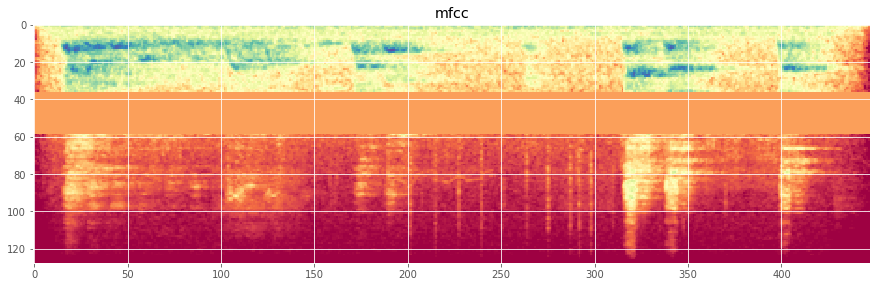

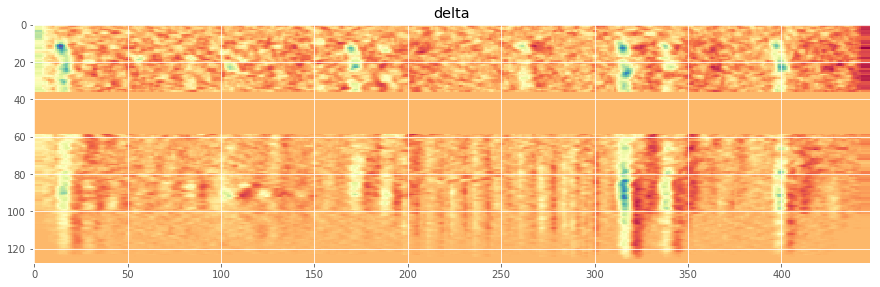

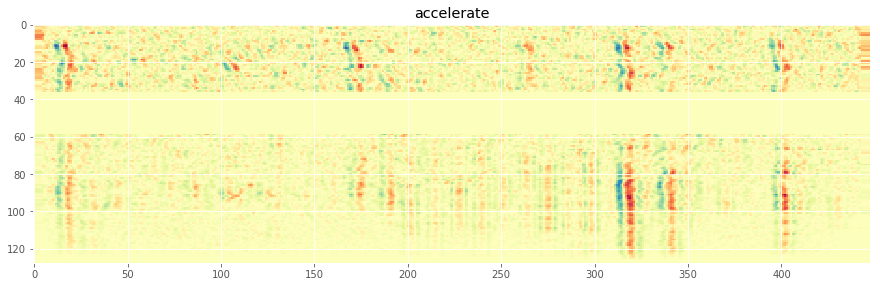

In [24]:
import random
import torch
def freq_mask(data, F=30, num_masks=1, replace_with_zero=False):
    spec = data.copy()   # data.shape = (3, n_mel, xx)
    num_mel_channels = spec.shape[1]

    mask_value_list = []
    for i_channel in range(spec.shape[0]):
        mask_value_list.append(spec[i_channel].mean())

    for i in range(num_masks):
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        if f_zero == f_zero + f:
            # avoids randrange error if values are equal and range is empty
            return spec

        mask_end = random.randrange(f_zero, f_zero + f)
        if replace_with_zero:
            for i_channel in range(spec.shape[0]):
                spec[i_channel, f_zero:mask_end, :] = 0
        else:
            for i_channel in range(spec.shape[0]):
                # mask_value = np.random.rand()
                mask_value = mask_value_list[i_channel]
                spec[i_channel, f_zero:mask_end, :] = mask_value

    return spec


fe_freq_mask = freq_mask(fe_sc, F=40, num_masks=2, replace_with_zero=False)
print(fe_freq_mask.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

(3, 128, 448)


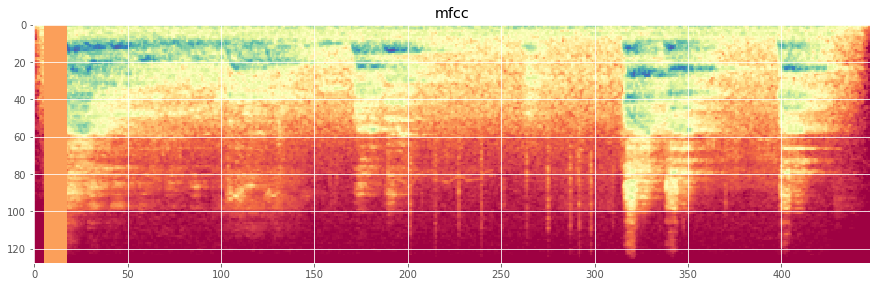

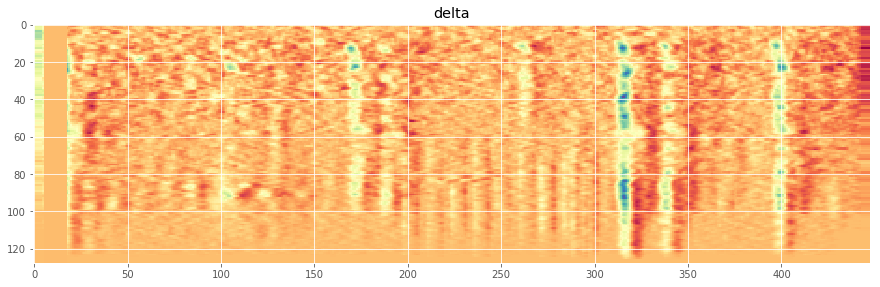

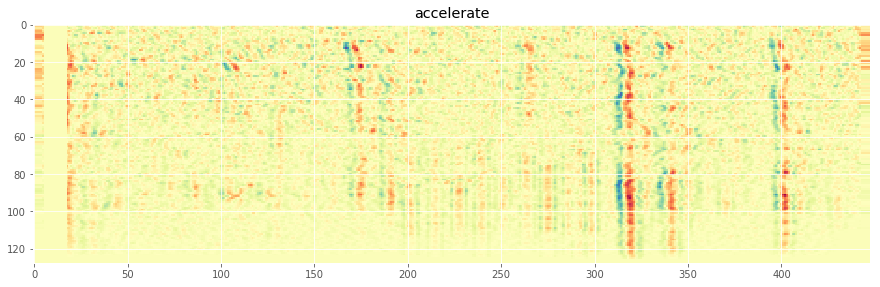

In [23]:
def time_mask(data, T=30, num_masks=1, replace_with_zero=False):
    spec = data.copy()   # data.shape = (3, n_mel, xx)
    len_spectro = spec.shape[2]

    mask_value_list = []
    for i_channel in range(spec.shape[0]):
        mask_value_list.append(spec[i_channel].mean())

    for i in range(num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        if t_zero == t_zero + t:
            # avoids randrange error if values are equal and range is empty
            return spec

        mask_end = random.randrange(t_zero, t_zero + t)
        if replace_with_zero:
            for i_channel in range(spec.shape[0]):
                spec[i_channel, :, t_zero:mask_end] = 0
        else:
            for i_channel in range(spec.shape[0]):
                # mask_value = np.random.rand()
                mask_value = mask_value_list[i_channel]
                spec[i_channel, :, t_zero:mask_end] = mask_value

    return spec

fe_freq_mask = time_mask(fe_sc, T=20, num_masks=2, replace_with_zero=False)
print(fe_freq_mask.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

(3, 128, 448)


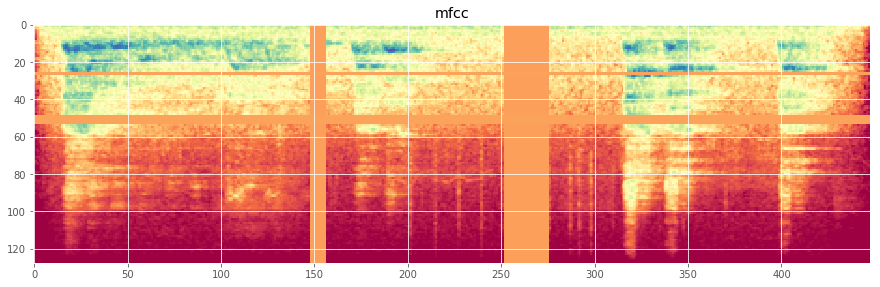

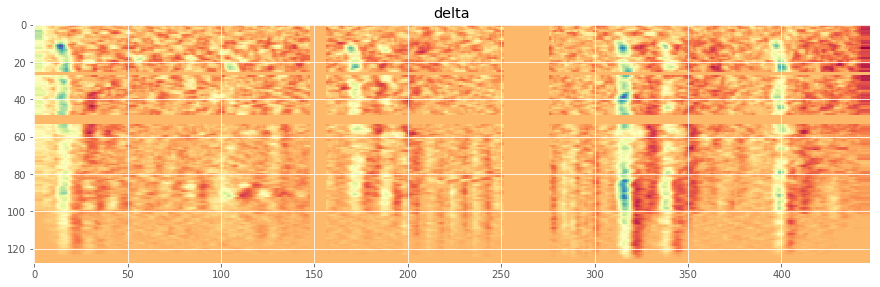

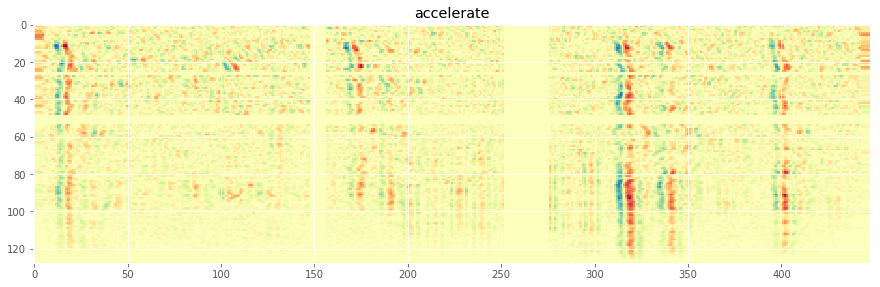

In [34]:
fe_freq_mask = freq_mask(time_mask(fe_sc, T=40, num_masks=2, replace_with_zero=False), F=40, num_masks=2)
print(fe_freq_mask.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");